# Intro to Julia

This notebook is an introduction to the Julia language and its commonly used IJulia/Jupyter notebook interface. It is based on:
- material developed by Miles Lubin and Sebastien Martin of the MIT Operations Research Center
- Arthur Delarue's COS 2018 notebook (https://github.com/PhilChodrow/cos_2018/tree/master/6_julia_and_jump)
- online open-source material (http://ucidatascienceinitiative.github.io/IntroToJulia/Html/WhyJulia)
- Christopher Rackauckas' fantastic blogs (https://www.stochasticlifestyle.com/7-julia-gotchas-handle/)

## Why Julia?
Quoting the old Julia website:

> Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments. It provides a sophisticated compiler, distributed parallel execution, numerical accuracy, and an extensive mathematical function library.

Let's unpack this.

A **high-level** language:

Easy to use and learn, with a similar syntax to Python/Matlab.
It is possible to do complicated computations quickly.
For example, Solving $Ax = b$ with $A = \begin{pmatrix}
 1 & 2 &  3\\ 
 2 & 1 & 2\\ 
 3 & 2 & 1
\end{pmatrix}$ and $b = \begin{pmatrix}
 1 \\ 
 1 \\ 
 1 
\end{pmatrix}$ is as simple as:

In [4]:
A = [1 2 3
     2 1 2
     3 2 1]

b = [1,1,1]
A \ b

3-element Array{Float64,1}:
 0.25
 0.0
 0.25000000000000006

A **dynamic** language:

Julia is, like Python, Matlab or R, a dynamic language: you can interact with the language without the need to compile your code. Static or compiled languages, like C or Fortran, are more complicated to use but generally faster, and thus used when there is a need for time-efficient computations.

Two-language approach: use high level languages for research and scripting, then translate the final result into a static language for performance.

A **high-performance** language:

Julia is fast. Thanks to multiple dispatch, a strong type system, and just-in-time compilation, it can reach performance comparable to C and Fortran.


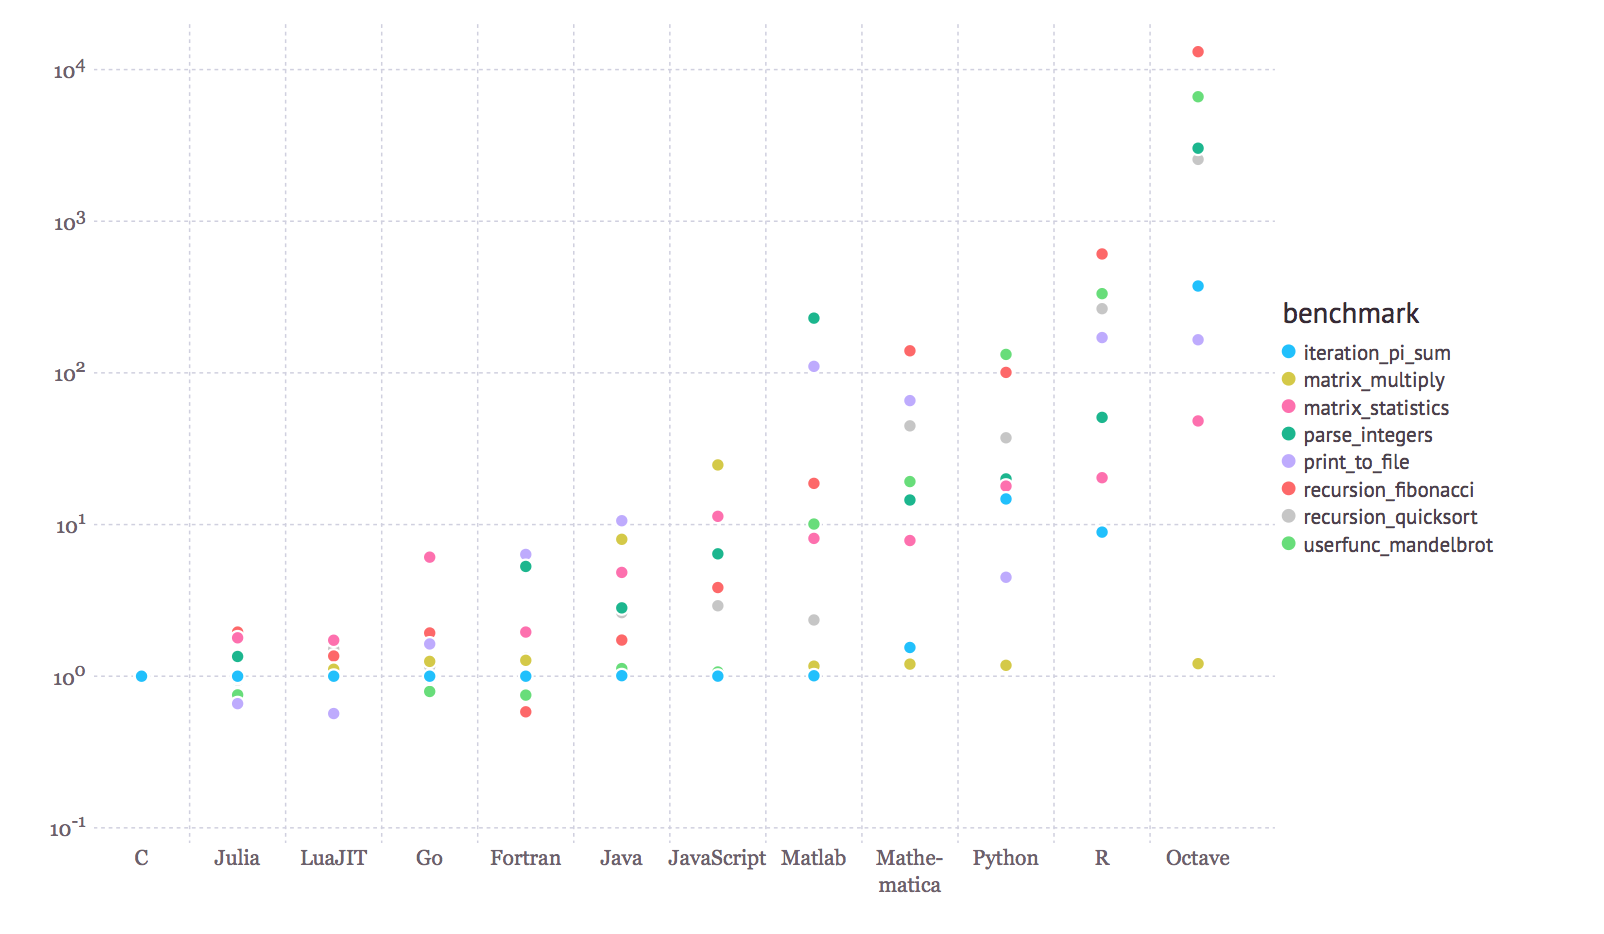

A language for **technical computing**:

- Julia has a lot of built in functions for scientific computing.
- A growing number of packages, mostly written in Julia itself.
- More and more users in Finance, Biology, Optimization.
- Can run C and Python code seamlessly (using Scikit for Machine Learning...)

Do the getting comfortable with a notebook stuff as a preassignment?

In this notebook we will try to cover some gotchas and good workflow practices to get the most out of Julia. 

## Warm-up exercise

Complete `find_entering_var` below, which returns the minimum reduced cost and index of the entering variable (with the minimum reduced cost), inside an iteration of the simplex method. 

If no variable has negative reduced cost, we will simply return zeros for `min_rc` and `min_idx`. If multiple variables have the lowest reduced cost, we will return the last of these.

Remember the vector of reduced costs is given by:
$$
rc = c_N - A'\pi
$$
and the $i^{th}$ reduced cost is
$$
rc_i = c_i - A_i' \pi
$$
where $A_i$ is the $i^{th}$ column of $A$.

You might find it useful to use the function `dot` from the `LinearAlgebra` library.

In [3]:
using LinearAlgebra
dot([1, 2], [3, 4])

11

In [1]:
function find_entering_var(A::Matrix{Float64}, c::Vector{Float64}, pi::Vector{Float64}, var_status::Vector{Int})
    min_rc = 0
    min_idx = 0
    for k in eachindex(var_status)
        # only check nonbasic variables
        if iszero(var_status[k])
            ################################
            # You do this part
            ################################
            min_rc = 0
            min_idx = 0
            @inbounds for k in eachindex(var_status)
                # only check nonbasic variables
                if iszero(var_status[k])
                    rc = c[k] - dot(A[:, k], pi)
                    if rc < min_rc
                        min_rc = rc
                        min_idx = k
                    end
                end
            end
        end
    end
    return (min_rc, min_idx)
end

find_entering_var (generic function with 1 method)

In [4]:
# test your function by running this cell

using Random
function make_data(T::Type)
Random.seed!(1)
    basic_idxs = [2, 4, 6]
    A = T[3 2 1 2 1 0 0; 1 1 1 1 0 1 0; 4 3 3 4 0 0 1]
    B = A[:, basic_idxs]
    B_inv = inv(B) # note this would never happen inside the algorithm, we always have B_inv available
    b = T[225, 117, 420]
    c = -T[19, 13, 12, 17, 0, 0, 0]
    c_b = c[basic_idxs]
    x_b = B_inv * b
    var_status = [0, 1, 0, 2, 0, 3]
    pi = B_inv' * c_b
    return (A, b, c, B_inv, pi, var_status, basic_idxs)
end
(A, b, c, B_inv, pi, var_status, basic_idxs) = make_data(Float64)

find_entering_var(A, c, pi, var_status) # should be (-1.5, 1)

(-1.5, 1)

### A bit more on why Julia is fast




In [4]:
# When we write a function, it can have many "methods"
+(1, 2)

3

In [5]:
methods(+)

# 166 methods for generic function "+":
[1] +(x::Bool, z::Complex{Bool}) in Base at complex.jl:286
[2] +(x::Bool, y::Bool) in Base at bool.jl:96
[3] +(x::Bool) in Base at bool.jl:93
[4] +(x::Bool, y::T) where T<:AbstractFloat in Base at bool.jl:104
[5] +(x::Bool, z::Complex) in Base at complex.jl:293
[6] +(a::Float16, b::Float16) in Base at float.jl:398
[7] +(x::Float32, y::Float32) in Base at float.jl:400
[8] +(x::Float64, y::Float64) in Base at float.jl:401
[9] +(z::Complex{Bool}, x::Bool) in Base at complex.jl:287
[10] +(z::Complex{Bool}, x::Real) in Base at complex.jl:301
[11] +(::Missing, ::Missing) in Base at missing.jl:114
[12] +(::Missing) in Base at missing.jl:100
[13] +(::Missing, ::Number) in Base at missing.jl:115
[14] +(level::Base.CoreLogging.LogLevel, inc::Integer) in Base.CoreLogging at logging.jl:107
[15] +(c::BigInt, x::BigFloat) in Base.MPFR at mpfr.jl:413
[16] +(a::BigInt, b::BigInt, c::BigInt, d::BigInt, e::BigInt) in Base.GMP at gmp.jl:515
[17] +(a::BigInt, b::BigInt, c::BigInt, d::BigInt) in Base.GMP at gmp.jl:514
[18] +(a::BigInt, b::BigInt, c::BigInt) in Base.GMP at gmp.jl:513
[19] +(x::BigInt, y::BigInt) in Base.GMP at gmp.jl:473
[20] +(x::BigInt, c::Union{UInt16, UInt32, UInt8}) in Base.GMP at gmp.jl:521
[21] +(x::BigInt, c::Union{Int16, Int32, Int8}) in Base.GMP at gmp.jl:527
[22] +(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat, e::BigFloat) in Base.MPFR at mpfr.jl:563
[23] +(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat) in Base.MPFR at mpfr.jl:556
[24] +(a::BigFloat, b::BigFloat, c::BigFloat) in Base.MPFR at mpfr.jl:550
[25] +(x::BigFloat, c::BigInt) in Base.MPFR at mpfr.jl:409
[26] +(x::BigFloat, y::BigFloat) in Base.MPFR at mpfr.jl:378
[27] +(x::BigFloat, c::Union{UInt16, UInt32, UInt8}) in Base.MPFR at mpfr.jl:385
[28] +(x::BigFloat, c::Union{Int16, Int32, Int8}) in Base.MPFR at mpfr.jl:393
[29] +(x::BigFloat, c::Union{Float16, Float32, Float64}) in Base.MPFR at mpfr.jl:401
[30] +(x::Dates.CompoundPeriod, y::Dates.CompoundPeriod) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\periods.jl:341
[31] +(x::Dates.CompoundPeriod, y::Dates.Period) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\periods.jl:339
[32] +(x::Dates.CompoundPeriod, y::Dates.TimeType) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\periods.jl:369
[33] +(x::Dates.Date, y::Dates.Day) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:74
[34] +(x::Dates.Date, y::Dates.Week) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:72
[35] +(dt::Dates.Date, z::Dates.Month) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:55
[36] +(dt::Dates.Date, y::Dates.Year) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:28
[37] +(dt::Dates.Date, t::Dates.Time) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:19
[38] +(t::Dates.Time, dt::Dates.Date) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:20
[39] +(x::Dates.Time, y::Dates.TimePeriod) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:78
[40] +(dt::Dates.DateTime, z::Dates.Month) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:48
[41] +(dt::Dates.DateTime, y::Dates.Year) in Dates at C:\Users\lkape\AppData\Local\Programs\Julia\Julia-1.4.0-DEV\share\julia\stdlib\v1.4\Dates\src\arithmetic.jl:24
[42] +(x::Dates.DateTime, y::Dates.Period) in Dates at C:\Users\lkape

We could have made `find_entering_var` more general e.g. we could have a simplex running in rational numbers, arbitrary precision, etc.!

In [13]:
# E.g. 
1 // 2 # fraction in Julia
typeof(1 // 2)

Rational{Int64}

In [5]:
function find_entering_var(A::Matrix{T}, c::Vector{T}, pi::Vector{T}, var_status::Vector{Int}) where {T <: Real}
    min_rc = 0
    min_idx = 0
    for k in eachindex(var_status)
        # only check nonbasic variables
        if iszero(var_status[k])
            ################################
            # Copy your code from before
            ################################
            min_rc = 0
            min_idx = 0
            for k in eachindex(var_status)
                # only check nonbasic variables
                if iszero(var_status[k])
                    rc = c[k] - dot(A[:, k], pi)
                    if rc < min_rc
                        min_rc = rc
                        min_idx = k
                    end
                end
            end
        end
    end
    return (min_rc, min_idx)
end

find_entering_var (generic function with 2 methods)

In [6]:
# let's generate some rational data
(A, b, c, B_inv, pi, var_status, basic_idxs) = make_data(Rational{Int})
@show A
@show b
@show c
;

A = Rational{Int64}[3//1 2//1 1//1 2//1 1//1 0//1 0//1; 1//1 1//1 1//1 1//1 0//1 1//1 0//1; 4//1 3//1 3//1 4//1 0//1 0//1 1//1]
b = Rational{Int64}[225//1, 117//1, 420//1]
c = Rational{Int64}[-19//1, -13//1, -12//1, -17//1, 0//1, 0//1, 0//1]


In [7]:
# test that this "just works" by running this cell
(min_rc, min_idx) = find_entering_var(A, c, pi, var_status) # should be (-3//2, 1)

(-3//2, 1)

When multiple methods are available, Julia executes the method with the "most specific" type signature.

In [1]:
function myFunction(x)
    println("Default output")
end

function myFunction(x::Int) # only called when x is an integer
    println("You gave me an integer!")
end

myFunction(1.0)
myFunction(1)
myFunction("ORC")

Default output
You gave me an integer!
Default output


In [7]:
# you can check which method will be dispatched to with @which
@which myFunction(1.0)
@which myFunction("ORC")
@which myFunction(1)

myFunction(x::Int64) in Main at In[1]:6

If we have type-stability (more later), Julia can infer the types of all variables in our functions based on the types of its arguments. Using this information the appropriate methods are precompiled. 

Implication: If the types of all variables are fixed, our code runs "like" that of a static language, every time we run a method, some precompiled code is executed for the types we are using. 

Let's make this more concrete.

In [8]:
@code_llvm 2 * 5


;  @ int.jl:54 within `*'
; Function Attrs: uwtable
define i64 @"julia_*_13304"(i64, i64) #0 {
top:
  %2 = mul i64 %1, %0
  ret i64 %2
}


In [9]:
@code_llvm 2.0 * 5.0


;  @ float.jl:405 within `*'
; Function Attrs: uwtable
define double @"julia_*_17847"(double, double) #0 {
top:
  %2 = fmul double %0, %1
  ret double %2
}


In [88]:
function count_up(n)
    count = 0.0
    for i in 1:n
        count += sin(1.0) + cos(1.0) + tan(1.0)
    end
    return count
end
println("First use: slower")
@time count_up(100) 
println("Second use: compiled and optimized automatically")
@time count_up(100);

First use: slower
  0.000006 seconds
Second use: compiled and optimized automatically
  0.000002 seconds


Aside: always run twice when using @time

### What is type stability?

In [20]:
@code_warntype find_entering_var(A, c, pi, var_status)

Variables
  #self#::Core.Compiler.Const(find_entering_var, false)
  A::Array{Rational{Int64},2}
  c::Array{Rational{Int64},1}
  pi::Array{Rational{Int64},1}
  var_status::Array{Int64,1}
  min_rc::Any
  min_idx::Int64
  @_8::Union{Nothing, Tuple{Int64,Int64}}
  k::Int64
  rc::Any

Body::Tuple{Any,Int64}
1 ─       (min_rc = Main.zero($(Expr(:static_parameter, 1))))
│         (min_idx = 0)
│   %3  = Main.eachindex(var_status)::Base.OneTo{Int64}
│         (@_8 = Base.iterate(%3))
│   %5  = (@_8 === nothing)::Bool
│   %6  = Base.not_int(%5)::Bool
└──       goto #7 if not %6
2 ┄       Core.NewvarNode(:(rc))
│   %9  = @_8::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (k = Core.getfield(%9, 1))
│   %11 = Core.getfield(%9, 2)::Int64
│   %12 = Base.getindex(var_status, k)::Int64
│   %13 = Main.iszero(%12)::Bool
└──       goto #5 if not %13
3 ─ %15 = Base.getindex(c, k)::Rational{Int64}
│   %16 = Base.getindex(A, Main.:(:), k)::Array{Rational{Int64},1}
│   %17 = Main.dot(%16, pi)::Any
│      

We see that `A`, `c`, and `pi` are rational, but the type of `min_rc` is not necessarily fixed throughout our function.

Let's try to fix our function to get rid of the red.

In [27]:
function find_entering_var(A::Matrix{T}, c::Vector{T}, pi::Vector{T}, var_status::Vector{Int}) where {T <: Real}
    min_rc = zero(T) # <----------------
    min_idx = 0
    for k in eachindex(var_status)
        # only check nonbasic variables
        if iszero(var_status[k])
            rc = c[k] - dot(A[:, k], pi)
            if rc < min_rc
                min_rc = rc
                min_idx = k
            end
        end
    end
    return (min_rc, min_idx)
end

@code_warntype find_entering_var(A, c, pi, var_status)

Variables
  #self#::Core.Compiler.Const(find_entering_var, false)
  A::Array{Rational{Int64},2}
  c::Array{Rational{Int64},1}
  pi::Array{Rational{Int64},1}
  var_status::Array{Int64,1}
  min_rc::Rational{Int64}
  min_idx::Int64
  @_8::Union{Nothing, Tuple{Int64,Int64}}
  k::Int64
  rc::Rational{Int64}

Body::Tuple{Rational{Int64},Int64}
1 ─       (min_rc = Main.zero($(Expr(:static_parameter, 1))))
│         (min_idx = 0)
│   %3  = Main.eachindex(var_status)::Base.OneTo{Int64}
│         (@_8 = Base.iterate(%3))
│   %5  = (@_8 === nothing)::Bool
│   %6  = Base.not_int(%5)::Bool
└──       goto #7 if not %6
2 ┄       Core.NewvarNode(:(rc))
│   %9  = @_8::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (k = Core.getfield(%9, 1))
│   %11 = Core.getfield(%9, 2)::Int64
│   %12 = Base.getindex(var_status, k)::Int64
│   %13 = Main.iszero(%12)::Bool
└──       goto #5 if not %13
3 ─ %15 = Base.getindex(c, k)::Rational{Int64}
│   %16 = Base.getindex(A, Main.:(:), k)::Array{Rational{Int64},1}
│   

Other useful functions include `eltype()` or `one()`.

## Exercise
Complete the function `find_leaving_var` to return `(min_ratio, min_idx)`. I.e. the minimum and the minimizer of:
$$
\min_{k: e_k' B^{-1} A_i > 0} \frac{e_k' B^{-1}b}{e_k' B^{-1} A_i}
$$
If $ e_k' B^{-1} A_i \leq 0 $ for all $k$, return (0, Inf). Assume you are provided the vectors `B_inv_A_i = B \ A_i`, and `x_b = B \ b`, as well as a list of basic indices as input.

Test for correctness and type stability by running the box below. 

In [10]:
function find_leaving_var(x_b::Vector{T}, B_inv_A_i::Vector{T}, basic_idxs::Vector{Int}) where {T <: Real}
    min_ratio = T(Inf)
    min_idx = 0
    for k in eachindex(B_inv_A_i)
        if B_inv_A_i[k] > 0
            ratio = x_b[k] / B_inv_A_i[k]
            if ratio < min_ratio
                min_ratio = ratio
                min_idx = k
            end
        end
    end
    return (min_ratio, min_idx)
end

find_leaving_var (generic function with 1 method)

In [11]:
# use our data and entering variable from before
(A, b, c, B_inv, pi, var_status, basic_idxs) = make_data(Float64)
(_, entering_idx) = find_entering_var(A, c, pi, var_status)
x_b = B_inv * b
B_inv_A_i = B_inv * A[:, entering_idx]


(min_ratio, leaving_idx) = find_leaving_var(x_b, B_inv_A_i, basic_idxs) # should be (14.999999999999993, 1)

(14.999999999999993, 1)

In [8]:
@code_warntype find_leaving_var(x_b, B_inv_A_i, basic_idxs)

Variables
  #self#::Core.Compiler.Const(find_leaving_var, false)
  x_b::Array{Float64,1}
  B_inv_A_i::Array{Float64,1}
  basic_idxs::Array{Int64,1}
  min_ratio::Float64
  min_idx::Int64
  @_7::Union{Nothing, Tuple{Int64,Int64}}
  k::Int64
  ratio::Float64

Body::Tuple{Float64,Int64}
1 ─       (min_ratio = ($(Expr(:static_parameter, 1)))(Main.Inf))
│         (min_idx = 0)
│   %3  = Main.eachindex(B_inv_A_i)::Base.OneTo{Int64}
│         (@_7 = Base.iterate(%3))
│   %5  = (@_7 === nothing)::Bool
│   %6  = Base.not_int(%5)::Bool
└──       goto #7 if not %6
2 ┄       Core.NewvarNode(:(ratio))
│   %9  = @_7::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (k = Core.getfield(%9, 1))
│   %11 = Core.getfield(%9, 2)::Int64
│   %12 = Base.getindex(B_inv_A_i, k)::Float64
│   %13 = (%12 > 0)::Bool
└──       goto #5 if not %13
3 ─ %15 = Base.getindex(x_b, k)::Float64
│   %16 = Base.getindex(B_inv_A_i, k)::Float64
│         (ratio = %15 / %16)
│   %18 = (ratio < min_ratio)::Bool
└──       goto #5 if

### Using the REPL

Working in the REPL doesn't allow type specification:

In [101]:
a = 3
f() = a
@code_warntype f()

Variables
  #self#::Core.Compiler.Const(f, false)

Body::Any
1 ─     return Main.a


In [28]:
# wrap code inside functions/modules when possible
function foo()
    a = 3
    f() = a
    return f()
end
@code_warntype foo()

Variables
  #self#::Core.Compiler.Const(foo, false)
  a::Int64
  f::var"#f#7"{Int64}

Body::Int64
1 ─      (a = 3)
│   %2 = Main.:(var"#f#7")::Core.Compiler.Const(var"#f#7", false)
│   %3 = Core.typeof(a::Core.Compiler.Const(3, false))::Core.Compiler.Const(Int64, false)
│   %4 = Core.apply_type(%2, %3)::Core.Compiler.Const(var"#f#7"{Int64}, false)
│        (f = %new(%4, a::Core.Compiler.Const(3, false)))
│   %6 = (f::Core.Compiler.Const(var"#f#7"{Int64}(3), false))()::Core.Compiler.Const(3, false)
└──      return %6


In [12]:
const my_const = 3
f() = my_const
@code_warntype f()

Variables
  #self#::Core.Compiler.Const(f, false)

Body::Int64
1 ─     return Main.my_const


## Matrices and views

In [4]:
A = [3 5; 8 12]
@show A
B = A
B[1, 1] = 1
@show A
@show B

A = [3 5; 8 12]
A = [1 5; 8 12]
B = [1 5; 8 12]


2×2 Array{Int64,2}:
 1   5
 8  12

In [21]:
using BenchmarkTools

In [39]:
A = randn(100, 100); # random 100x100 matrix with elements from N(0,1)
@benchmark B = A # set the value of B to point to the same location as A

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.399 ns (0.00% GC)
  median time:      1.600 ns (0.00% GC)
  mean time:        1.792 ns (0.00% GC)
  maximum time:     31.500 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [21]:
B = A[1:2, 44:67]
@show B[1, 1]
@show A[1, 44]
B[1, 1] = 55
@show B[1, 1]
@show A[1, 44]

B[1, 1] = 0.28892965613318317
A[1, 44] = 0.28892965613318317
B[1, 1] = 55.0
A[1, 44] = 0.28892965613318317


0.28892965613318317

In [16]:
@benchmark B = A[1:2, 44:67]

BenchmarkTools.Trial: 
  memory estimate:  496 bytes
  allocs estimate:  1
  --------------
  minimum time:     117.795 ns (0.00% GC)
  median time:      121.616 ns (0.00% GC)
  mean time:        142.322 ns (2.63% GC)
  maximum time:     934.061 ns (68.30% GC)
  --------------
  samples:          10000
  evals/sample:     916

If we want to operate on `A[1:2, 44:67]`, using `A[1:2, 44:67]` creates a copy of the indexed elements in `A`. To avoid expensive copying, we can use the convenient `@views` macro.

In [22]:
@views B = A[1:2, 44:67]
@show B[1, 1]
@show A[1, 44]
B[1, 1] = 55
@show B[1, 1]
@show A[1, 44]

B[1, 1] = 0.28892965613318317
A[1, 44] = 0.28892965613318317
B[1, 1] = 55.0
A[1, 44] = 55.0


55.0

Doesn't imply that keeping views will always be better than storing a copy of a subarray.

What about operations on arrays

In [28]:
f(x) = 2x

f (generic function with 2 methods)

In [34]:
using Random
Random.seed!(1)
n = 500
my_vec = randn(n);

In [36]:
scratch_vec = copy(my_vec)
@benchmark scratch_vec = f(my_vec)

BenchmarkTools.Trial: 
  memory estimate:  4.06 KiB
  allocs estimate:  1
  --------------
  minimum time:     348.568 ns (0.00% GC)
  median time:      1.849 μs (0.00% GC)
  mean time:        1.933 μs (22.38% GC)
  maximum time:     28.593 μs (93.29% GC)
  --------------
  samples:          9187
  evals/sample:     280

In [39]:
@benchmark scratch_vec .= f(my_vec)

BenchmarkTools.Trial: 
  memory estimate:  4.09 KiB
  allocs estimate:  3
  --------------
  minimum time:     700.706 ns (0.00% GC)
  median time:      858.741 ns (0.00% GC)
  mean time:        1.191 μs (14.70% GC)
  maximum time:     46.545 μs (96.64% GC)
  --------------
  samples:          10000
  evals/sample:     143

In [38]:
@benchmark scratch_vec .= f.(my_vec)

BenchmarkTools.Trial: 
  memory estimate:  32 bytes
  allocs estimate:  2
  --------------
  minimum time:     265.714 ns (0.00% GC)
  median time:      286.667 ns (0.00% GC)
  mean time:        340.638 ns (0.16% GC)
  maximum time:     10.452 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     315

In [40]:
@benchmark @. scratch_vec = f(my_vec)

BenchmarkTools.Trial: 
  memory estimate:  32 bytes
  allocs estimate:  2
  --------------
  minimum time:     258.592 ns (0.00% GC)
  median time:      273.242 ns (0.00% GC)
  mean time:        328.621 ns (0.14% GC)
  maximum time:     8.712 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     355

In [98]:
(A, var_status, basic_idxs, c, B, pi) = make_F64_data()
@benchmark find_entering_var($A, $c, $pi, $var_status)

BenchmarkTools.Trial: 
  memory estimate:  692.14 MiB
  allocs estimate:  810002
  --------------
  minimum time:     152.371 ms (6.88% GC)
  median time:      154.538 ms (6.44% GC)
  mean time:        155.823 ms (6.48% GC)
  maximum time:     184.497 ms (5.78% GC)
  --------------
  samples:          33
  evals/sample:     1

In [97]:
function find_entering_var2(A::Matrix{Float64}, c::Vector{Float64}, pi::Vector{Float64}, var_status::Vector{Int})
    min_rc = 0.0
    min_idx = 0
    for k in eachindex(var_status)
        # only check nonbasic variables
        if iszero(var_status[k])
            @views rc = c[k] - dot(A[:, k], pi)
            if rc < min_rc
                min_rc = rc
                min_idx = k
            end
        end
    end
    return (min_rc, min_idx)
end
@benchmark find_entering_var2($A, $c, $pi, $var_status)

BenchmarkTools.Trial: 
  memory estimate:  42.19 KiB
  allocs estimate:  900
  --------------
  minimum time:     39.000 μs (0.00% GC)
  median time:      39.799 μs (0.00% GC)
  mean time:        47.595 μs (2.83% GC)
  maximum time:     2.156 ms (95.47% GC)
  --------------
  samples:          10000
  evals/sample:     1

undecided Aside: TimerOutputs

In [14]:
using LinearAlgebra
using TimerOutputs
const my_timer = TimerOutput()

function find_entering_var_3(A::Matrix{T}, c::Vector{T}, pi::Vector{T}, var_status::Vector{Int}) where {T <: Real}
    min_rc = 0
    min_idx = 0
    @timeit my_timer "loop" for k in eachindex(var_status)
        # only check nonbasic variables
        if iszero(var_status[k])
            min_rc = 0
            min_idx = 0
            for k in eachindex(var_status)
                # only check nonbasic variables
                if iszero(var_status[k])
                    @timeit my_timer "calc_rc" rc = c[k] - dot(A[:, k], pi)
                    if rc < min_rc
                        min_rc = rc
                        min_idx = k
                    end
                end
            end
        end
    end
    return (min_rc, min_idx)
end

reset_timer!(my_timer)
find_entering_var_3(A, c, pi, var_status)
print_timer(my_timer)

 ────────────────────────────────────────────────────────────────────
                             Time                   Allocations      
                     ──────────────────────   ───────────────────────
  Tot / % measured:       695ms / 0.00%           90.2MiB / 0.00%    

 Section     ncalls     time   %tot     avg     alloc   %tot      avg
 ────────────────────────────────────────────────────────────────────


 loop             1   8.60μs   100%  8.60μs   1.83KiB  100%   1.83KiB
   calc_rc        9   4.50μs  52.3%   500ns   0.98KiB  53.8%     112B
 ────────────────────────────────────────────────────────────────────

In [16]:
function find_entering_var_3(A::Matrix{T}, c::Vector{T}, pi::Vector{T}, var_status::Vector{Int}) where {T <: Real}
    min_rc = 0
    min_idx = 0
    @timeit my_timer "loop" for k in eachindex(var_status)
        # only check nonbasic variables
        if iszero(var_status[k])
            min_rc = 0
            min_idx = 0
            for k in eachindex(var_status)
                # only check nonbasic variables
                if iszero(var_status[k])
                    @timeit my_timer "calc_rc" @views rc = c[k] - dot(A[:, k], pi)
                    if rc < min_rc
                        min_rc = rc
                        min_idx = k
                    end
                end
            end
        end
    end
    return (min_rc, min_idx)
end

reset_timer!(my_timer)
find_entering_var_3(A, c, pi, var_status)
print_timer(my_timer)

 ────────────────────────────────────────────────────────────────────
                             Time                   Allocations      
                     ──────────────────────   ───────────────────────
  Tot / % measured:       133ms / 0.01%           10.4MiB / 0.01%    

 Section     ncalls     time   %tot     avg     alloc   %tot      avg
 ────────────────────────────────────────────────────────────────────
 loop             1   12.7μs   100%  12.7μs   1.27KiB  100%   1.27KiB
   calc_rc        9   2.90μs  22.8%   322ns      432B  33.3%    48.0B
 ────────────────────────────────────────────────────────────────────

Complete the function `tableau_update` which updates `B_inv` and `x_b` using only the vector `B_inv_A_i = B \ A[:, i]` as well as the index of the leaving variable.

Recall that one of the "tricks" of the revised simplex method is that we only need to keep track of $B^{-1}$ throughout the algorithm and a single column of $B^{-1}A$ (the column of the entering variable).

Let $Q$ be an elementary matrix such that applying $Q$ to $B^{-1}A_i$ gives the $j^{th}$ unit vector, where $j$ is the index of the leaving variable. All we need to do is apply the action of $Q$ to $B^{-1}$ and $x_b$ (apply the same elementary row operations). 

$$
\begin{align*}
x_{b_j} & \leftarrow x_{b_j} \div (B^{-1}A_i)_j \\
B^{-1}_{j,l} & \leftarrow B^{-1}_{j,l} \div (B^{-1}A_i)_j & \quad \forall l = 1, \ldots, m \\
x_{b_k} & \leftarrow x_{b_k} - x_{b_j} \times (B^{-1}A_i)_k \div (B^{-1}A_i)_j  & \quad \forall k \neq j \\
B^{-1}_{k,l} & \leftarrow B^{-1}_{k,l} - B^{-1}_{j,l} \times (B^{-1}A_i)_{k,l} \div (B^{-1}A_i)_{j,l}
& \quad \forall l = 1, \ldots, m, \forall k \neq j
\end{align*}
$$


In [22]:
function tableau_update(B_inv::Matrix{T}, B_inv_A_i::Vector{T}, x_b::Vector{T}, leaving_ind::Int) where {T <: Real}
    B_inv[leaving_ind, :] ./= B_inv_A_i[leaving_ind]
    x_b[leaving_ind] /= B_inv_A_i[leaving_ind]
    for k in eachindex(B_inv_A_i)
        if k != leaving_ind
            B_inv[k , :] .-= B_inv[leaving_ind, :] * B_inv_A_i[k]
            x_b[k] -= x_b[leaving_ind] * B_inv_A_i[k]
        end
    end
    return
end

tableau_update (generic function with 1 method)

Test your function by running the cell below.

In [23]:
# use our data and entering variable from before
(A, b, c, B_inv, pi, var_status, basic_idxs) = make_data(Float64)
(_, entering_idx) = find_entering_var(A, c, pi, var_status)
x_b = B_inv * b
B_inv_A_i = B_inv * A[:, entering_idx]
(_, leaving_ind) = find_leaving_var(x_b, B_inv_A_i, basic_idxs) # should be (14.999999999999993, 1)

# move to a new basis
tableau_update(B_inv, B_inv_A_i, x_b, leaving_ind)
@show x_b # should be [15, 90, 12]
@show B_inv # should be [1 0 -0.5; -1 0 0.75; 0 1 -0.25]
;


x_b = [14.999999999999993, 90.00000000000001, 11.999999999999996]
B_inv = [0.9999999999999998 -0.0 -0.4999999999999999; -0.9999999999999997 0.0 0.7499999999999998; -1.1102230246251565e-16 1.0 -0.24999999999999994]


In [24]:
@benchmark tableau_update(B_inv, B_inv_A_i, x_b, leaving_ind)

BenchmarkTools.Trial: 
  memory estimate:  784 bytes
  allocs estimate:  7
  --------------
  minimum time:     295.413 ns (0.00% GC)
  median time:      327.917 ns (0.00% GC)
  mean time:        396.739 ns (4.77% GC)
  maximum time:     7.195 μs (95.12% GC)
  --------------
  samples:          10000
  evals/sample:     240

In [27]:
function tableau_update2(B_inv::Matrix{T}, B_inv_A_i::Vector{T}, x_b::Vector{T}, leaving_ind::Int) where {T <: Real}
    @views B_inv[leaving_ind, :] ./= B_inv_A_i[leaving_ind]
    x_b[leaving_ind] /= B_inv_A_i[leaving_ind]
    @inbounds for k in eachindex(B_inv_A_i)
        if k != leaving_ind
            @views B_inv[k , :] .-= B_inv[leaving_ind, :] .* B_inv_A_i[k]
            x_b[k] -= x_b[leaving_ind] * B_inv_A_i[k]
        end
    end
    return
end
@benchmark tableau_update2(B_inv, B_inv_A_i, x_b, leaving_ind)

BenchmarkTools.Trial: 
  memory estimate:  384 bytes
  allocs estimate:  8
  --------------
  minimum time:     94.632 ns (0.00% GC)
  median time:      106.842 ns (0.00% GC)
  mean time:        130.743 ns (8.15% GC)
  maximum time:     2.537 μs (90.99% GC)
  --------------
  samples:          10000
  evals/sample:     950

### Other tips:
- Type `?` at the REPL and the name of a function/struct to search for docs
- Type `;` in the REPL to acess the command line
- `cntrl`/`cmd` + `r` and type the start of a command to bakcward search your command history in the REPL
- `cntrl`/`cmd` + `s` to forward search
- `tab` for unicode, e.g.: `\pi` + `tab`
- Checkout the package `Revise.jl` to avoid having to recompile repos